<a href="https://colab.research.google.com/github/vignejs/cover-song-identification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Convolutional Neural Network for Cover song identification

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons==0.9.1

In [ ]:
import os
import sys
import random
import numpy as np
import cv2
import time
import pickle
import itertools as it
import pandas as pd
from scipy.linalg import block_diag
from scipy import interpolate
from pathlib import Path
from tqdm import tqdm
from joblib import Parallel, delayed
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn.metrics.pairwise import euclidean_distances
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Layer, BatchNormalization, Lambda, ZeroPadding2D, ReLU, Average, Permute
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback, CSVLogger
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Tensorflow version 2.3.0


### Load data

In [ ]:
feature_type = "chroma_cens"
spect_len = 500

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    root = Path("/content/drive/My Drive/cosoid")
else:
    root = Path.cwd()

traindf = pd.HDFStore(root / 'datasets' / 'trainset.h5').select(feature_type)
valdf = pd.HDFStore(root / 'datasets' / 'valset.h5').select(feature_type)

In [ ]:
traindf = traindf.groupby(by='work_id').filter(lambda x: len(x) == 13 * 12)

In [ ]:
train = traindf.values.reshape(1000, 13, 12, 500)
val = valdf.values.reshape(5000, 2, 12, 500)

In [ ]:
def gen_indexes(w_shape, p_shape):
    """generates combination of pair of indices for siamese input
        w_shape: no of works
        p_shape: no of performances
    """
    indexes = list()
    
    p = list(it.permutations(range(p_shape), 2))
    
    r = range(w_shape)
    for i in r:
        np.random.seed(0)
        rand = np.random.choice([x for x in r if x != i], size=len(p), replace=False)
        for j, (x, y) in enumerate(p):
            indexes.append([(i,x), (i,y)])
            indexes.append([(i, x), (rand[j], y)])
            
    return indexes

In [ ]:
indexes_train = gen_indexes(1000, 13)
indexes_val = gen_indexes(4000, 2)

### Using keras.seqential

In [ ]:
class DataGenerator(keras.utils.Sequence):
    '''Generates data for Keras'''
    def __init__(self, data, indexes, batch_size=100, dim=(12, 1000), n_channels=1, shuffle=False, val=False):
        '''Initialization'''
        self.dim = dim
        self.data = data
        self.val = val
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.indexes = indexes    
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.indexes) / self.batch_size)) 

    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # return data
        return self.__data_generation(indexes)

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        if self.shuffle:
            np.random.shuffle(self.indexes)   
    
    def __data_augmentor(self, a):
        
        rng = int(np.random.normal() * spect_len)
        aug = np.roll(a, rng, axis=1)

        rng = int(np.random.normal() * 12)
        aug = np.roll(aug, rng, axis=0)
        
        times = np.arange(0, spect_len)
        func = interpolate.interp1d(times, aug, kind='nearest', fill_value='extrapolate')
            
        if np.random.uniform() < 0.3:
            
            rng = 1 + np.random.normal()  # random number to determine the factor of time stretching

            if 0.7 <= rng <= 1.3:
                times = np.linspace(0, spect_len - 1, int(spect_len * rng))
                aug = func(times)  # applying time stretching
                
        if np.random.uniform() < 0.3:
            rng = np.random.uniform()  # random number to determine which operation to apply for time warping

            if rng < 0.3:  # silence
                # each frame has a probability of 0.1 to be silenced
                silence_idxs = np.random.choice([False, True], size=times.size, p=[.9, .1])
                aug[:, silence_idxs] = np.zeros((12, 1))

            elif rng < 0.7:  # duplicate
                # each frame has a probability of 0.15 to be duplicated
                duplicate_idxs = np.random.choice([False, True], size=times.size, p=[.85, .15])
                times = np.sort(np.concatenate((times, times[duplicate_idxs])))
                aug = func(times)

            else:  # remove
                # each frame has a probability of 0.1 to be removed
                remaining_idxs = np.random.choice([False, True], size=times.size, p=[.1, .9])
                times = times[remaining_idxs]
                aug = func(times)

        
        if aug.shape[1] > spect_len:
            aug = aug[:, :spect_len]
        else:
            aug = np.pad(aug, ((0, 0), (0, spect_len - aug.shape[1])), 'wrap')   

        return aug
    
    def _data_augmentor(self, a):
        if self.val:
            return a
        else:
            return self.__data_augmentor(a)

    def __data_generation(self, indexes):
        '''Generates data containing batch_size samples''' # X : (n_samples, *dim, n_channels)
        # Initialization
        X1 = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        X2 = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        Y = np.empty((self.batch_size, 1), dtype=np.int)

        # Generate data
        for i, (x, y) in enumerate(indexes):
            # sample sample
            r1 = self.data[x]
            r2 = self.data[y]

            # augment sample
            r1 = self._data_augmentor(r1)
            r2 = self._data_augmentor(r2)

            # store sample
            X1[i, ] = r1.reshape(12, spect_len, 1)
            X2[i, ] = r2.reshape(12, spect_len, 1)

            # Store class
            if x[0] == y[0]:
                Y[i, ] = [0]
            else:
                Y[i, ] = [1]     

        return [X1, X2], np.array(Y, dtype="float32")

In [ ]:
# Parameters
params = {'dim': (12, spect_len),
          'batch_size': 128,
          'n_channels': 1,
          'shuffle': True}

training_generator = DataGenerator(train, indexes_train, **params)
validation_generator = DataGenerator(val, indexes_val, **params, val=True)

def tr_generator():
    multi_enqueuer = tf.keras.utils.OrderedEnqueuer(training_generator, use_multiprocessing=True, shuffle=False)
    multi_enqueuer.start(workers=4, max_queue_size=5)
    while True:
        yield next(multi_enqueuer.get())

def va_generator():
    multi_enqueuer = tf.keras.utils.OrderedEnqueuer(validation_generator, use_multiprocessing=True, shuffle=False)
    multi_enqueuer.start(workers=4, max_queue_size=5)
    while True:
        yield next(multi_enqueuer.get())


training_dataset = tr_generator()
validation_dataset = va_generator()

### ADAMScheduler

In [ ]:
class ADAMScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = ADAMScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.learning_rate, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('learning_rate', []).append(K.get_value(self.model.optimizer.learning_rate))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.learning_rate, self.clr())
    
    def on_epoch_begin(self, epoch, logs=None):
        self.ep_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        print(f"Current learning rate {K.get_value(self.model.optimizer.learning_rate)}")
        print(f"Elapsed time : {time.time() - self.ep_start:.2f}s")
        if epoch + 1 == self.next_restart:
            print('Restarts')
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
            self.model.save(root / "weights/weights.best-{:.2e}-epoch-{:05d}.hdf5".format(self.model.count_params(), epoch + 1))

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

### Siamese Architecture

In [ ]:
def squared_differences(pair_of_tensors):
    x, y = pair_of_tensors
    return K.square(x - y)

def l2_norm(x, axis=None):
    """
    takes an input tensor and returns the l2 norm along specified axis
    """

    square_sum = K.sum(K.square(x), axis=axis, keepdims=True)
    norm = K.sqrt(K.maximum(square_sum, K.epsilon()))

    return norm

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1) 

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def acc(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

def W_init(shape, dtype=None):
    """Initialize weights"""
    values = np.random.normal(loc=0, scale=1e-2, size=shape)
    return K.variable(values, dtype=dtype)

def W_init_dense(shape, dtype=None):
    """Initialize weights"""
    values = np.random.normal(loc=0, scale=2e-1, size=shape)
    return K.variable(values, dtype=dtype)
 
def b_init(shape, dtype=None):
    """Initialize bias"""
    values = np.random.normal(loc=0.5, scale=1e-2, size=shape)
    return K.variable(values, dtype=dtype)

In [ ]:
def create_base_network(input_shape):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(3, 0), input_shape=input_shape))
    model.add(Conv2D(32, (7, 7), strides=(1, 3), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(ZeroPadding2D(padding=(2, 0)))
    model.add(Conv2D(32, (5, 5), strides=(1, 2), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(BatchNormalization())

    model.add(ZeroPadding2D(padding=(2, 0)))
    model.add(Conv2D(32, (5, 5), strides=(1, 2), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(BatchNormalization())

    model.add(ZeroPadding2D(padding=(2, 0)))
    model.add(Conv2D(32, (5, 5), strides=(2, 2), kernel_initializer=W_init, bias_initializer=b_init))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid', kernel_initializer=W_init_dense, bias_initializer=b_init))
    print(model.summary())

    return model

def create_twin():
    input_shape = (12, spect_len, 1)
    original_input = Input(shape=input_shape, name="input_1")
    cover_input = Input(shape=input_shape, name="input_2")
    model = create_base_network(input_shape)
    original_model = model(original_input)
    cover_model = model(cover_input)

    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([original_model, cover_model])

    output = Dense(1, activation='sigmoid')(L1_distance)

    model = Model(inputs=[original_input, cover_input], outputs=[output])

    return model

model = create_twin()
best_weights_file = "{}/weights/weights.best-{:.2e}.hdf5".format(root, model.count_params())

opt = tfa.optimizers.AdamW(weight_decay=1e-4, learning_rate=1e-2)

custom_objects = {"contrastive_loss": contrastive_loss,
                  "acc": acc,
                  "W_init": W_init,
                  "W_init_dense": W_init_dense,
                  "b_init": b_init}

# model = load_model(best_weights_file, custom_objects=custom_objects)
model.compile(loss=contrastive_loss, optimizer=opt, metrics=[acc])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 18, 500, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 12, 165, 32)       1600      
_________________________________________________________________
re_lu (ReLU)                 (None, 12, 165, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 165, 32)       128       
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 16, 165, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 81, 32)        25632     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 12, 81, 32)        0

### Training

In [ ]:
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

csv_logger = CSVLogger(f"{root}/logs/training-{model.count_params():.2e}.csv", append=False)

lr_schedule = ADAMScheduler(min_lr=0,
                            max_lr=1e-2,
                            steps_per_epoch=len(training_generator),
                            lr_decay=0.9,
                            cycle_length=50,
                            mult_factor=1)

callbacks = [checkpoint, lr_schedule, csv_logger]

In [ ]:
# Train model on dataset (sequence)
history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    steps_per_epoch=len(training_generator),
                    validation_steps=len(validation_generator),
                    use_multiprocessing=False,
                    workers=1,
                    verbose=1,
                    callbacks=callbacks,
                    epochs=100)

Epoch 1/100
2437/2437 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.6737
Epoch 00001: val_loss improved from inf to 0.58812, saving model to /content/drive/My Drive/cosoid/weights/weights.best-1.46e+05.hdf5
Current learning rate 0.009990133345127106
Elapsed time : 97.11s
2437/2437 [==============================] - 94s 38ms/step - loss: 0.5980 - accuracy: 0.6737 - val_loss: 0.5881 - val_accuracy: 0.6936
Epoch 2/100
2436/2437 [============================>.] - ETA: 0s - loss: 0.5142 - accuracy: 0.7443
Epoch 00002: val_loss did not improve from 0.58812
Current learning rate 0.00996057316660881
Elapsed time : 92.74s
2437/2437 [==============================] - 93s 38ms/step - loss: 0.5142 - accuracy: 0.7443 - val_loss: 0.5973 - val_accuracy: 0.6896
Epoch 3/100
2437/2437 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.7676
Epoch 00003: val_loss improved from 0.58812 to 0.44761, saving model to /content/drive/My Drive/cosoid/weights/weights.

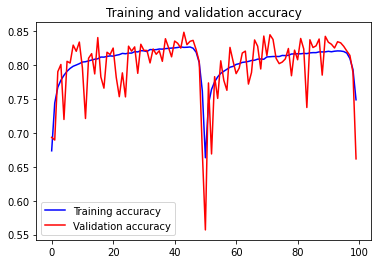

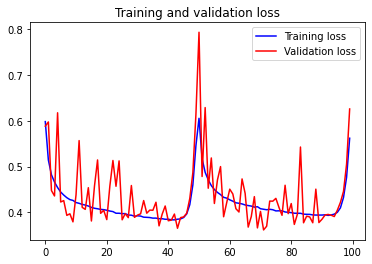

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()